# Νευρωνικά Δίκτυα

Παρακάτω θα παρουσιάσουμε μερικές αρχιτεκτονικές νευρωνικών δικτύων.

***

## Συναρτήσεις 

Οι παρακάτω βοηθητικές συναρτήσεις θα χρησιμοποιηθούν για να κάνουμε train και test το μοντέλο.

Αρχικά κάνουμε τα απαραίτητα imports και ορίζουμε την συσκευή που θα χρησιμοποιήσουμε (cpu/gpu).

In [1]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device, imports complete!'.format(device))

Using cuda device, imports complete!


Στην συνέχεια ορίζουμε την πρώτη συνάρτηση η οποία δέχεται ένα μοντέλο, το training dataset, την συνάρτηση λάθους, τον optimizer, και την συσκευή που χρησιμοποιούμε. Προχωράει το training κατά ένα βήμα και επιστρέφει την απώλεια.

In [14]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = 'cpu'):
    model.to(device)
    model.train()

    train_loss = 0
    for X_batch, y_batch in data_loader:
        # Send data to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        y_pred = model(X_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent gradients exploding
        optimizer.step()

        train_loss += loss.item()
    
    return train_loss


Ομοίως η παρακάτω συνάρτηση κάνει test το μοντέλο σε κάθε εποχή, και επιστρέφει την απώλεια.

In [15]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = 'cpu'):
    model.to(device)
    model.eval()

    test_loss = 0
    with torch.inference_mode():
        for X_batch, y_batch in data_loader:
            # Send data to GPU
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_test_pred = model(X_batch)
            test_loss += loss_fn(y_test_pred, y_batch).item()
    
    return test_loss

Η βασική συνάρτηση, επαναληπτικά για όσες εποχές έχουμε διαλέξει κάνει train και test το μοντέλο, και ανά 10 εποχές εκτυπώνει τα αποτελέσματα. Επιστρέφει 2 πίνακες με τις συνολικές απώλειες σε κάθε επανάληψη.

In [16]:
def train_test_model(epoch : int, 
                     model: torch.nn.Module,
                     train_loader: torch.utils.data.DataLoader,
                     test_loader: torch.utils.data.DataLoader,
                     loss_fn: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     scheduler,
                     device: torch.device = 'cpu'):
    torch.manual_seed(42)
    train_loss_arr = []
    test_loss_arr = []
    for epochs in range(epoch):
        epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
        train_loss_arr.append(epoch_loss / len(train_loader))

        scheduler.step(epoch_loss)
        after_lr = optimizer.param_groups[0]['lr']

        test_loss = test_step(model, test_loader, loss_fn, device)
        test_loss_arr.append(test_loss / len(test_loader))

        if (epochs) % 10 == 0 or epochs == 0:
            print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]} | Loss test: {test_loss_arr[-1]} | lr = {after_lr}')
        elif epochs + 1 == epoch:
            print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]} | Loss test: {test_loss_arr[-1]} | lr = {after_lr}')
    
    return train_loss_arr, test_loss_arr

Η συνάρτηση είναι παρόμοια με την test_step με την διαφορά ότι επιστρέφει ένα dictionary με τα βασικά στοιχεία του μοντέλου.

In [17]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               device: torch.device = 'cpu'):
    loss = 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
        loss /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item()
            }

Η συνάρτηση αυτή χρησιμοποιείται για να εμφανίσει τις κανονικοποιημένες στο (0,1) train_loss και test_loss curves.

In [18]:
def plot_results(train_arr, test_arr):
    # Plot the loss curves
    train_arr = (train_arr - np.min(train_arr)) / (np.max(train_arr) - np.min(train_arr))
    test_arr = (test_arr - np.min(test_arr)) / (np.max(test_arr) - np.min(test_arr))
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_arr, label='Train Loss')
    plt.plot(test_arr, label='Test Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Normalized Loss")
    plt.title("Normalized Training Loss")
    plt.grid()
    plt.legend()
    plt.show()

***

## Εισαγωγή δεδομένων

Η συνάρτηση αυτή δέχεται τα paths των δεδομένων, δημιουργεί και επιστρέφει τα mini_batches που θα χρησιμοποιηθούν στο training.

In [19]:
def data_func(input_path, labels_path, batch_size = 32, test_size = 0.2):
    input_array = np.load(input_path)
    labels = np.load(labels_path)

    # Reshape the tensor to 2D so that it can be used in the linear model
    X = input_array.reshape(len(input_array), -1)
    y = labels

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    scaler = StandardScaler()
    # Fit the scaler on the training data and transform both the training and test sets
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Transform the data to PyTorch tensors and move them to the GPU if available
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Define the dataset
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    # Define the data loader
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader

In [26]:
train_loader, test_loader = data_func('Data.npy', 'Labels.npy')

***

## Αρχιτεκτονικές

### Αρχιτεκτονική 1

Το πρώτο μας μοντέλο θα είναι η απλούστερη περίπτωση ενός γραμμικού layer με είσοδο το ```input_size``` δηλαδή 4000 (για την ώρα) , και έξοδο 2 (x,y), χωρίς για αρχή κάποια συνάρτηση ενεργοποίησης.

Σαν συνάρτηση λάθους θα χρησιμοποιηθεί η ```MSELoss``` ενώ σαν optimizers θα δοκιμαστούν οι ```Adam```, ```RMSProp```, ```SGD```.

In [28]:
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= output_size),  
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 6.727279105901718 | Loss test: 1.1352466959506273 | lr = 0.01
Epoch 10 | Loss train: 1.9502951340675354 | Loss test: 1.78660025075078 | lr = 0.01
Epoch 20 | Loss train: 0.12074540394544601 | Loss test: 0.1633451695088297 | lr = 0.001
Epoch 30 | Loss train: 0.12209001356363297 | Loss test: 0.10568062961101532 | lr = 0.001
Epoch 40 | Loss train: 0.08678908997774124 | Loss test: 0.08908949140459299 | lr = 0.0001
Epoch 50 | Loss train: 0.08662972894310951 | Loss test: 0.08782583137508482 | lr = 0.0001
Epoch 60 | Loss train: 0.08694533789157867 | Loss test: 0.09652317932341248 | lr = 0.0001
Epoch 70 | Loss train: 0.08291614899039268 | Loss test: 0.08597471250686795 | lr = 1e-05
Epoch 80 | Loss train: 0.08276245641708374 | Loss test: 0.08771928073838353 | lr = 1e-05
Epoch 90 | Loss train: 0.08307899448275566 | Loss test: 0.08699796989094466 | lr = 1e-05
Epoch 100 | Loss train: 0.08297582426667213 | Loss test: 0.08596444048453122 | lr = 1e-05


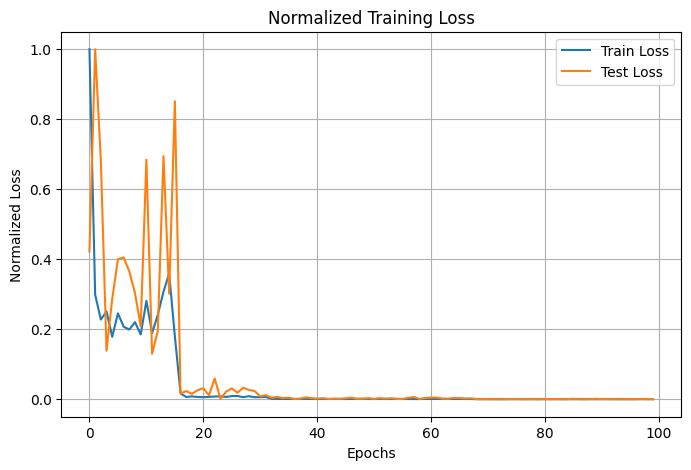

In [29]:
input_len = 4000
output_len = 2

# Instantiate the model
model_0 = SimpleModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate)

# Initialize the scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 100,model = model_0, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

Χρησιμοποιήσαμε τον optimizer ``` Adam ``` τώρα θα χρησιμοποιήσουμε τον ``` RMSProp```

Epoch 0 | Loss train: 389.34333584785463 | Loss test: 86.48615956306458 | lr = 0.01
Epoch 10 | Loss train: 52.400199691772464 | Loss test: 63.33684730529785 | lr = 0.01
Epoch 20 | Loss train: 0.6328850021362304 | Loss test: 0.752026878297329 | lr = 0.001
Epoch 30 | Loss train: 0.6301612060070038 | Loss test: 0.5582231441512704 | lr = 0.001
Epoch 40 | Loss train: 0.6314166984558105 | Loss test: 0.6337330369278789 | lr = 0.001
Epoch 50 | Loss train: 0.10605190941691399 | Loss test: 0.12181497202254832 | lr = 0.0001
Epoch 60 | Loss train: 0.10640314549207687 | Loss test: 0.10324287018738687 | lr = 0.0001
Epoch 70 | Loss train: 0.1055651848912239 | Loss test: 0.1131214878987521 | lr = 0.0001
Epoch 80 | Loss train: 0.105792510420084 | Loss test: 0.1076981162186712 | lr = 0.0001
Epoch 90 | Loss train: 0.10374713322520256 | Loss test: 0.10589931695722044 | lr = 0.0001
Epoch 100 | Loss train: 0.10295733246207238 | Loss test: 0.11081597208976746 | lr = 0.0001


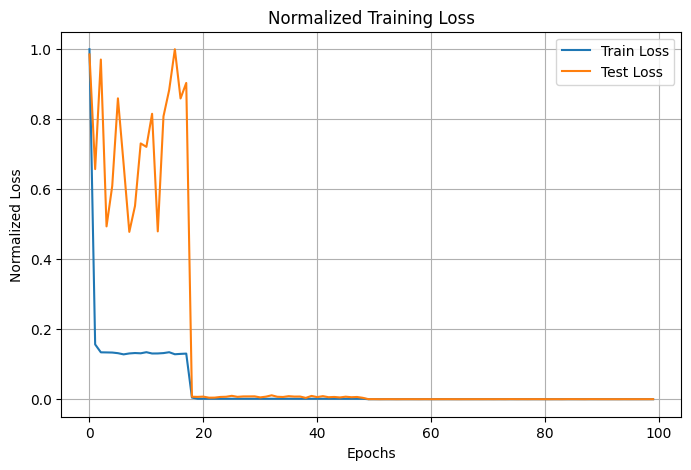

In [30]:
input_len = 4000
output_len = 2

# Instantiate the model
model_1 = SimpleModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(model_1.parameters(), lr=learning_rate)

# Initialize the scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 100,model = model_1, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

Και τέλος χρησιμοποιούμε και τον ``` SGD ```

Epoch 0 | Loss train: 1.1640131194591523 | Loss test: 0.47273494862020016 | lr = 0.01
Epoch 10 | Loss train: 0.15520274472236634 | Loss test: 0.15105919097550213 | lr = 0.01
Epoch 20 | Loss train: 0.16102961832284926 | Loss test: 0.18077260185964406 | lr = 0.01
Epoch 30 | Loss train: 0.0945454126894474 | Loss test: 0.09773271600715816 | lr = 0.001
Epoch 40 | Loss train: 0.0916035458445549 | Loss test: 0.0972577256616205 | lr = 0.001
Epoch 50 | Loss train: 0.08906628036499023 | Loss test: 0.08735592348966748 | lr = 0.001
Epoch 60 | Loss train: 0.08862284067273139 | Loss test: 0.09329615463502705 | lr = 0.001
Epoch 70 | Loss train: 0.09020187237858772 | Loss test: 0.09194227680563927 | lr = 0.001
Epoch 80 | Loss train: 0.09168716335296631 | Loss test: 0.09845991479232907 | lr = 0.001
Epoch 90 | Loss train: 0.08356610211730003 | Loss test: 0.0868266283068806 | lr = 0.0001
Epoch 100 | Loss train: 0.08350146731734276 | Loss test: 0.08625349507201463 | lr = 0.0001


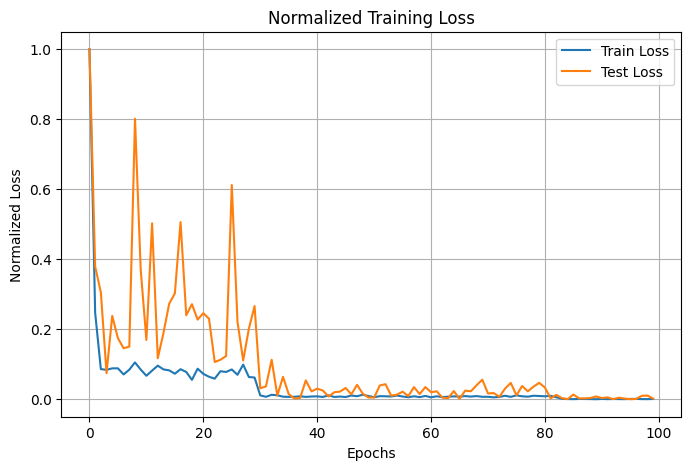

In [31]:
input_len = 4000
output_len = 2

# Instantiate the model
model_2 = SimpleModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=learning_rate, momentum= 0.9)

# Initialize the scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 100,model = model_2, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

Έχοντας προπονήσει τα μοντέλα για 100 εποχές με διαφορετικούς optimizers παρατηρούμε ότι η καλύτερη απόδοση έιναι από τον ``` Adam ``` ο οποίος θα χρησιμοποιηθεί και μετέπειτα.

***

### Αρχιτεκτονική 2

#### ReLU 128

Το δεύτερο μοντέλο μας θα αποκτήσει άλλα 2 layers δίνοντας μας την δυνατότητα θεωρητικά να πετύχουμε μικρότερη απώλεια συγκριτικά με την απλούστερη περίπτωση. Επιπλέον μας δίνεται η δυνατότητα να μεταβάλλουμε τόσο την μεταβλητή ```hidden_units``` που καθορίζει το μέγεθος των ενδιάμεσων επιπέδων, όσο και τις συναρτήσεις ενεργοποίησης.

Για αρχή επιλέγουμε την συνηθέστερη επιλογή την συνάρτηση ``` ReLU```, ο τύπος της οποίας δίνεται παρακάτω.

$ReLU(x) = max(0,x)$

In [32]:
from torch import nn

# Build the model

class ReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(ReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 4.489534070491791 | Loss test: 0.581901085563004 | lr = 0.01
Epoch 10 | Loss train: 0.23373226583003998 | Loss test: 0.12475496740080416 | lr = 0.01
Epoch 20 | Loss train: 0.12051465511322021 | Loss test: 0.13768633548170328 | lr = 0.01
Epoch 30 | Loss train: 0.10021373271942138 | Loss test: 0.14586019329726696 | lr = 0.01
Epoch 40 | Loss train: 0.06749944780766964 | Loss test: 0.040263294184114784 | lr = 0.01
Epoch 50 | Loss train: 0.07049050515890122 | Loss test: 0.2054570415057242 | lr = 0.01
Epoch 60 | Loss train: 0.010416498500853777 | Loss test: 0.009509391515166499 | lr = 0.001
Epoch 70 | Loss train: 0.0037837773524224756 | Loss test: 0.0037795205280417576 | lr = 0.001
Epoch 80 | Loss train: 0.0026087109851650895 | Loss test: 0.002062114992440911 | lr = 0.001
Epoch 90 | Loss train: 0.0019944829577580093 | Loss test: 0.0017020776776917046 | lr = 0.001
Epoch 100 | Loss train: 0.0021894540418870745 | Loss test: 0.0021013872319599614 | lr = 0.001


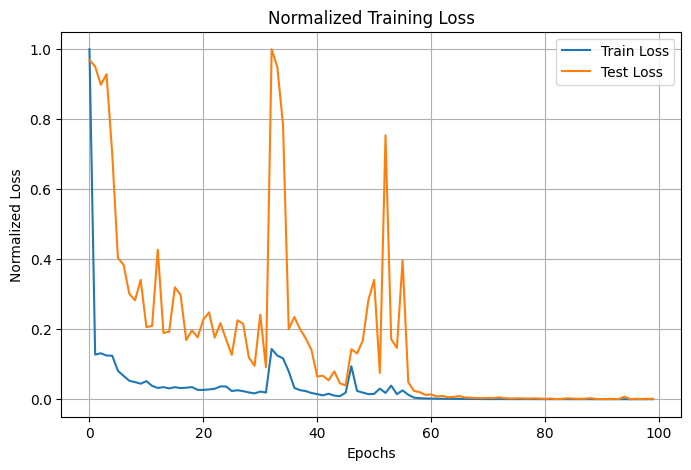

In [33]:
input_len = 4000
output_len = 2

# Instantiate the model
model_3 = ReLUModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=learning_rate)

# Initialize the scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 100,model = model_3, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

relu_model = eval_model(model_3, test_loader, loss_fn, device)

In [34]:
relu_model

{'model_name': 'ReLUModel', 'model_loss': 0.0021013871300965548}

Ήδη τα αποτελέσματα είναι πολύ καλύτερα συγκριτικά με την προηγούμενη αρχιτεκτονική.

#### ReLU 256

Τώρα θα αυξήσουμε τον αριθμό των ```hidden_units```  από 128 σε 256 για να δούμε κάποια πιθανή διαφορά.

Epoch 0 | Loss train: 32.524274733781816 | Loss test: 0.42252190969884396 | lr = 0.01
Epoch 10 | Loss train: 0.15551290440559387 | Loss test: 0.15625181957148015 | lr = 0.01
Epoch 20 | Loss train: 0.8617742040157318 | Loss test: 0.6309380559250712 | lr = 0.01
Epoch 30 | Loss train: 0.2348530085682869 | Loss test: 0.20840142923407257 | lr = 0.001
Epoch 40 | Loss train: 0.11073365890979767 | Loss test: 0.09470807830803096 | lr = 0.001
Epoch 50 | Loss train: 0.1025685413479805 | Loss test: 0.08839049469679594 | lr = 0.001
Epoch 60 | Loss train: 0.058662110149860384 | Loss test: 0.0478295442298986 | lr = 0.001
Epoch 70 | Loss train: 0.02691089690104127 | Loss test: 0.08325934421736747 | lr = 0.001
Epoch 80 | Loss train: 0.024597152549773453 | Loss test: 0.033790755085647106 | lr = 0.001
Epoch 90 | Loss train: 0.016829114086925983 | Loss test: 0.011764066424802877 | lr = 0.001
Epoch 100 | Loss train: 0.0177066419608891 | Loss test: 0.019553569494746625 | lr = 0.001


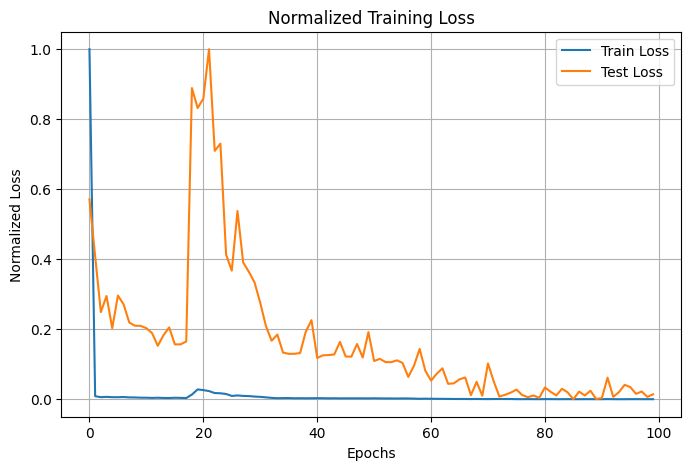

In [37]:
input_len = 4000
output_len = 2

# Instantiate the model
model_4 = ReLUModel(input_size=input_len, output_size=output_len, hidden_units= 256)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=learning_rate)

# Initialize the scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 100,model = model_4, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

relu_model_256 = eval_model(model_4, test_loader, loss_fn, device)

In [38]:
relu_model_256, relu_model

({'model_name': 'ReLUModel', 'model_loss': 0.019553570076823235},
 {'model_name': 'ReLUModel', 'model_loss': 0.0021013871300965548})

#### ReLU 64

Τα αποτελέσματα με 128 hidden units είναι σαφώς καλύτερα, δοκιμάζουμε τέλος με 64.

Epoch 0 | Loss train: 2.074717505455017 | Loss test: 0.24404863500967622 | lr = 0.01
Epoch 10 | Loss train: 0.016616015687584876 | Loss test: 0.02927725185872987 | lr = 0.01
Epoch 20 | Loss train: 0.047325240634381774 | Loss test: 0.021831739955814555 | lr = 0.01
Epoch 30 | Loss train: 0.008356558732688427 | Loss test: 0.006413827752112411 | lr = 0.001
Epoch 40 | Loss train: 0.0062346196305006745 | Loss test: 0.006944943088456057 | lr = 0.001
Epoch 50 | Loss train: 0.004828410439193249 | Loss test: 0.0039791191593394615 | lr = 0.001
Epoch 60 | Loss train: 0.0035558763686567543 | Loss test: 0.004193321947241202 | lr = 0.001
Epoch 70 | Loss train: 0.002658014633692801 | Loss test: 0.0030062352307140827 | lr = 0.001
Epoch 80 | Loss train: 0.002184320188127458 | Loss test: 0.0020818498014705256 | lr = 0.001
Epoch 90 | Loss train: 0.0022400545054115355 | Loss test: 0.003032886204891838 | lr = 0.001
Epoch 100 | Loss train: 0.002037340919021517 | Loss test: 0.0046988531612441875 | lr = 0.001


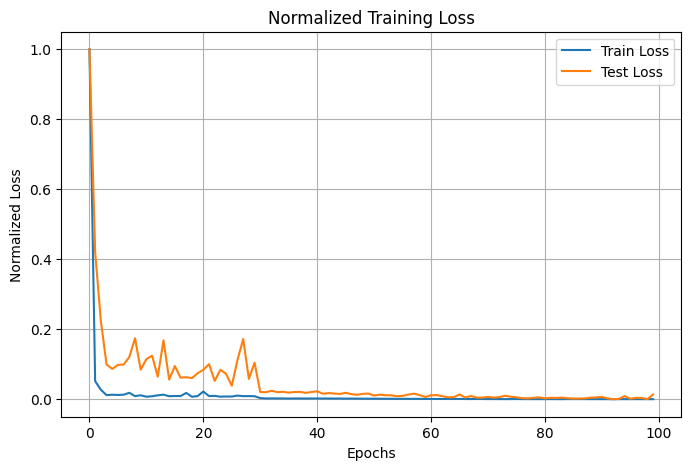

In [39]:
input_len = 4000
output_len = 2

# Instantiate the model
model_5 = ReLUModel(input_size=input_len, output_size=output_len, hidden_units= 64)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_5.parameters(), lr=learning_rate)

# Initialize the scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 100,model = model_5, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

relu_model_64 = eval_model(model_5, test_loader, loss_fn, device)

In [40]:
relu_model_256, relu_model_64, relu_model

({'model_name': 'ReLUModel', 'model_loss': 0.019553570076823235},
 {'model_name': 'ReLUModel', 'model_loss': 0.004698853008449078},
 {'model_name': 'ReLUModel', 'model_loss': 0.0021013871300965548})

Η καλύτερη περίπτωση φαίνεται να είναι με 128 ```hidden_units```

***

### Αρχιτεκτονική 2.1

#### LeakyRELU

Για την συγκεκριμένη αρχιτεκτονική και τα συγκεκριμένα ```hidden_units``` θα μελετήσουμε την διαφορά που προκαλούν διάφορες συναρτήσεις ενεργοποίησης.

Αρχικά μελετάμε την LeakyReLU, με τύπο:

$LeakyReLU(x) = max(0,x) + negative\_slope * min(0,x)$

In [41]:
class LeakyReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(LeakyReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 5.6506049607992175 | Loss test: 0.17045324249193072 | lr = 0.01
Epoch 10 | Loss train: 0.061391802057623866 | Loss test: 0.24993794388137758 | lr = 0.01
Epoch 20 | Loss train: 0.08782307927310466 | Loss test: 0.03796230140142143 | lr = 0.01
Epoch 30 | Loss train: 0.0035801092088222504 | Loss test: 0.0025808729296841193 | lr = 0.001
Epoch 40 | Loss train: 0.0025227832766249775 | Loss test: 0.0028834980294050183 | lr = 0.001
Epoch 50 | Loss train: 0.002137669953983277 | Loss test: 0.0011938158131670207 | lr = 0.001
Epoch 60 | Loss train: 0.001478339430410415 | Loss test: 0.0009460008604946779 | lr = 0.001
Epoch 70 | Loss train: 0.0011974468152038753 | Loss test: 0.0016201658490899717 | lr = 0.001
Epoch 80 | Loss train: 0.001026451280922629 | Loss test: 0.0010553710017120466 | lr = 0.001
Epoch 90 | Loss train: 0.0009936026504728944 | Loss test: 0.0008692417559359455 | lr = 0.001
Epoch 100 | Loss train: 0.00031868305441457777 | Loss test: 0.0002811564877447381 | lr = 

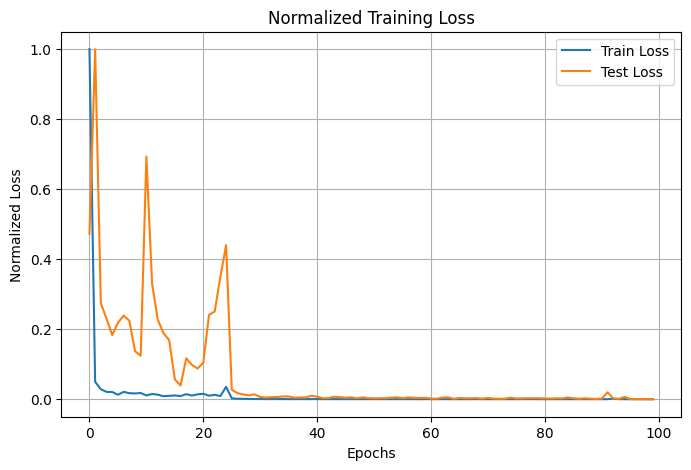

In [42]:
input_len = 4000
output_len = 2

# Instantiate the model
model_6 = LeakyReLUModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_6.parameters(), lr=learning_rate)

# Initialize the scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 100,model = model_6, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

leakyrelu = eval_model(model_6, test_loader, loss_fn, device)

#### Tanh

Δοκιμάζουμε την συνάρτηση ενεργοποίησης tanh. 

$tanh(x) = \frac{exp(x) - exp(-x)}{exp(x) + exp(-x)}$

In [43]:
class tanhModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(tanhModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 0.6510690288543701 | Loss test: 0.34811715222895145 | lr = 0.01
Epoch 10 | Loss train: 0.20225621378421785 | Loss test: 0.24781512562185526 | lr = 0.01
Epoch 20 | Loss train: 0.1738067525625229 | Loss test: 0.16468247398734093 | lr = 0.01
Epoch 30 | Loss train: 0.1905974287390709 | Loss test: 0.1872769189067185 | lr = 0.01
Epoch 40 | Loss train: 0.18542212575674058 | Loss test: 0.17303406121209264 | lr = 0.01
Epoch 50 | Loss train: 0.17679858642816543 | Loss test: 0.1593266287818551 | lr = 0.01
Epoch 60 | Loss train: 0.10660157185792923 | Loss test: 0.11916140303947031 | lr = 0.001
Epoch 70 | Loss train: 0.09908136332035064 | Loss test: 0.11043723090551794 | lr = 0.001
Epoch 80 | Loss train: 0.09540654987096786 | Loss test: 0.10645233187824488 | lr = 0.001
Epoch 90 | Loss train: 0.09470517241954804 | Loss test: 0.10782444546930492 | lr = 0.001
Epoch 100 | Loss train: 0.09308337289094924 | Loss test: 0.10555885965004563 | lr = 0.001


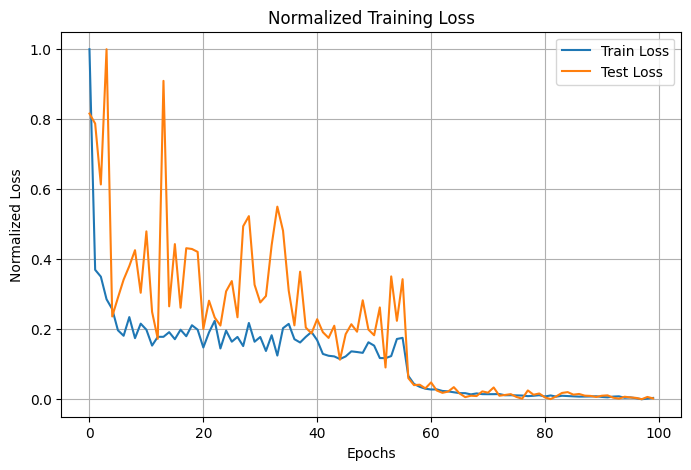

In [44]:
input_len = 4000
output_len = 2

# Instantiate the model
model_8 = tanhModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_8.parameters(), lr=learning_rate)

# Initialize the scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 100,model = model_8, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

tanh_model = eval_model(model_8, test_loader, loss_fn, device)

#### Sigmoid

$Sigmoid(x) = \frac{1}{1+exp(-x)}$

In [45]:
class sigmoidModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(sigmoidModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 0.35461315619945527 | Loss test: 0.18617303017526865 | lr = 0.01
Epoch 10 | Loss train: 0.11683636629581451 | Loss test: 0.1207577541936189 | lr = 0.01
Epoch 20 | Loss train: 0.11718394947052002 | Loss test: 0.16515237605199218 | lr = 0.01
Epoch 30 | Loss train: 0.08661188039183616 | Loss test: 0.1008021857123822 | lr = 0.001
Epoch 40 | Loss train: 0.08293568697571754 | Loss test: 0.09436651389114559 | lr = 0.001
Epoch 50 | Loss train: 0.0809548776447773 | Loss test: 0.09367199195548892 | lr = 0.001
Epoch 60 | Loss train: 0.07954031607508659 | Loss test: 0.09216569527052343 | lr = 0.001
Epoch 70 | Loss train: 0.07776674428582192 | Loss test: 0.08859269414097071 | lr = 0.001
Epoch 80 | Loss train: 0.07778006947040558 | Loss test: 0.08991005644202232 | lr = 0.001
Epoch 90 | Loss train: 0.07713023647665977 | Loss test: 0.09244874794967473 | lr = 0.001
Epoch 100 | Loss train: 0.07629434743523597 | Loss test: 0.09243151254486293 | lr = 0.001


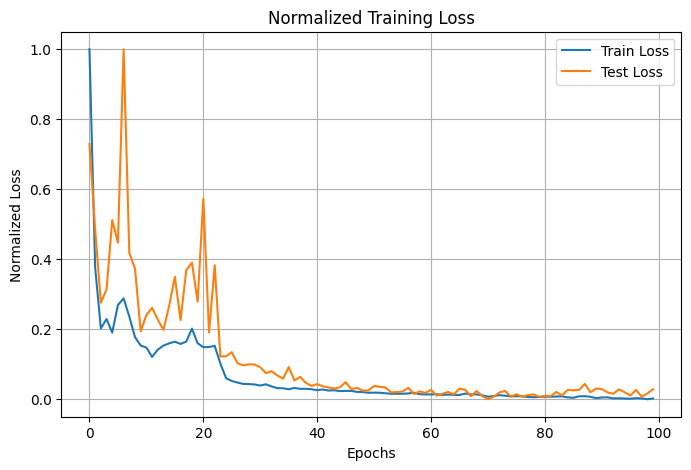

In [46]:
input_len = 4000
output_len = 2

# Instantiate the model
model_9 = sigmoidModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_9.parameters(), lr=learning_rate)

# Initialize the scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 100,model = model_9, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

sigmoid_model = eval_model(model_9, test_loader, loss_fn, device)

### Αρχιτεκτονική 3

Μιας και βλέπουμε ότι τα καλύτερα αποτελέσματα τα δίνει το μοντέλο με συνάρτηση ενεργοποίησης LeakyReLU , θα δοκιμάσουμε να βάλουμε άλλο ένα layer για να δούμε πως θα επηρεαστουν τα αποτελέσματα.

In [47]:
class LeakyReLUModel4(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(LeakyReLUModel4, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 1.9032922359704971 | Loss test: 0.16731470241211355 | lr = 0.01
Epoch 10 | Loss train: 0.134427575096488 | Loss test: 0.048042480542790145 | lr = 0.01
Epoch 20 | Loss train: 0.010350166022777557 | Loss test: 0.008236059598857537 | lr = 0.001
Epoch 30 | Loss train: 0.0060007548090070485 | Loss test: 0.005223666477832012 | lr = 0.001
Epoch 40 | Loss train: 0.003373895666562021 | Loss test: 0.00290954182491987 | lr = 0.001
Epoch 50 | Loss train: 0.002356404065620154 | Loss test: 0.002959123048640322 | lr = 0.001
Epoch 60 | Loss train: 0.0018343236185610293 | Loss test: 0.0015867846959736198 | lr = 0.001
Epoch 70 | Loss train: 0.0005002648514928296 | Loss test: 0.0004633265748452686 | lr = 0.0001
Epoch 80 | Loss train: 0.00030353006842778995 | Loss test: 0.0003048740547910711 | lr = 0.0001
Epoch 90 | Loss train: 0.00023599496902897954 | Loss test: 0.00023244265457833535 | lr = 0.0001
Epoch 100 | Loss train: 0.00023229280416853725 | Loss test: 0.00031953042207533144 | 

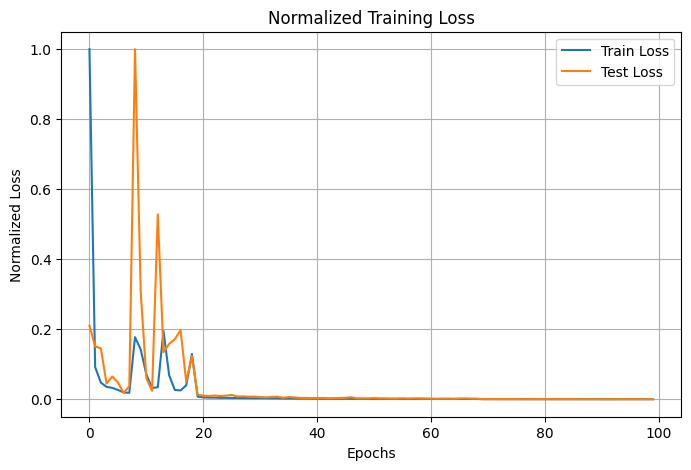

In [48]:
input_len = 4000
output_len = 2

# Instantiate the model
model_10 = LeakyReLUModel4(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_10.parameters(), lr=learning_rate)

# Initialize the scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 100,model = model_10, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

leakyrelu_4 = eval_model(model_10, test_loader, loss_fn, device)

Παρατηρούμε ότι η επίδοση του μοντέλου δεν καλυτέρεψε, άρα δεν χρειάζεται να προσθέσουμε και άλλα layers.

### Αρχιτεκτονική 4

#### Dropout

Θα προσθέσουμε ένα άλλο επίπεδο που συνίσταται σε μοντέλα με μικρά datasets, το ```Dropout```. Αυτό, με πιθανότητα p "νεκρώνει" έναν νευρώνα, βοηθώντας έτσι το μοντέλο να κατανοήσει γενικότερα συμπεράσματα για τα δεδομένα που του δίνουμε.

In [49]:
class LeakyReLUModelDropout(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(LeakyReLUModelDropout, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 6.3234088604450225 | Loss test: 0.5330344662070274 | lr = 0.01
Epoch 10 | Loss train: 0.22817648708820343 | Loss test: 0.251167185138911 | lr = 0.01
Epoch 20 | Loss train: 0.033565447717905046 | Loss test: 0.020618861890397966 | lr = 0.001
Epoch 30 | Loss train: 0.022414535634219645 | Loss test: 0.012912408506963402 | lr = 0.001
Epoch 40 | Loss train: 0.021248147204518317 | Loss test: 0.01499850323307328 | lr = 0.001
Epoch 50 | Loss train: 0.01989864233136177 | Loss test: 0.0194450874987524 | lr = 0.001
Epoch 60 | Loss train: 0.017593708015978336 | Loss test: 0.017316767130978405 | lr = 0.001
Epoch 70 | Loss train: 0.009512245450168847 | Loss test: 0.013648316846229136 | lr = 0.0001
Epoch 80 | Loss train: 0.009127353481948377 | Loss test: 0.013668582934769802 | lr = 0.0001
Epoch 90 | Loss train: 0.008573225270956754 | Loss test: 0.01360049145296216 | lr = 0.0001
Epoch 100 | Loss train: 0.008491223752498627 | Loss test: 0.01663851656485349 | lr = 0.0001
Epoch 110 |

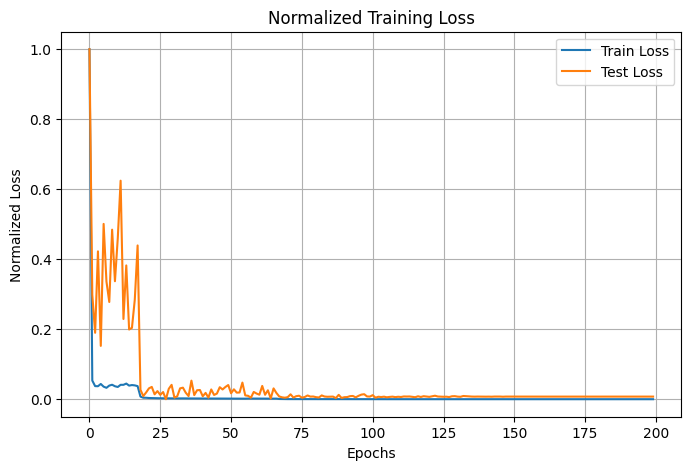

In [50]:
input_len = 4000
output_len = 2

# Instantiate the model
model_11 = LeakyReLUModelDropout(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_11.parameters(), lr=learning_rate)

# Initialize the scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_11, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

dropout_model = eval_model(model_11, test_loader, loss_fn, device)

## Results

In [51]:
compare_results = pd.DataFrame([leakyrelu, leakyrelu_4, relu_model,dropout_model, sigmoid_model, tanh_model])
compare_results

,model_name,model_loss
0,LeakyReLUModel,0.000281
1,LeakyReLUModel4,0.000320
2,ReLUModel,0.002101
3,LeakyReLUModelDropout,0.014476
4,sigmoidModel,0.092432
5,tanhModel,0.105559


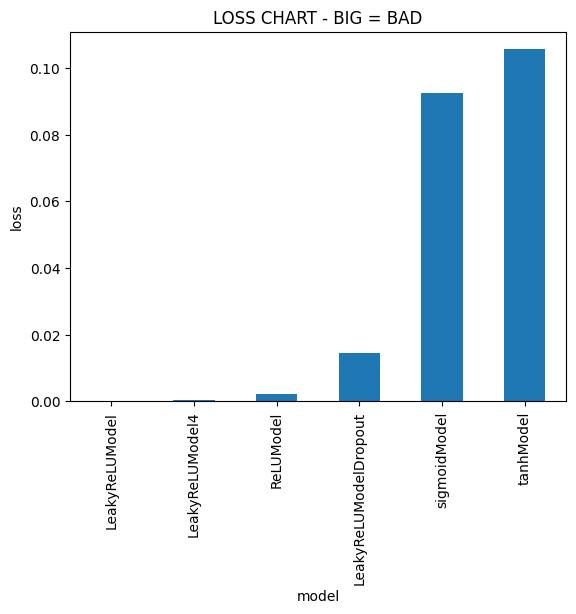

In [53]:
# Visualize our model results
compare_results.set_index("model_name")["model_loss"].plot(kind="bar")
plt.xlabel("model")
plt.ylabel("loss")
plt.title("LOSS CHART - BIG = BAD")
plt.show()

***